# Training on AG News

#### Baseline

In [6]:
import torch
from torchtext.datasets import AG_NEWS
import time
from models import BaselineModel
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torchtext.data.functional import to_map_style_dataset

from utils import collate_batch, yield_tokens
from trainer import Trainer
import functools

EPOCHS = 10  # epoch
LR = 0.5  # learning rate
BATCH_SIZE = 64  # batch size for training
EMBED_DIM = 64

tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(split="train")
num_class = len(set([label for (label, text) in train_iter]))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab = build_vocab_from_iterator(yield_tokens(train_iter, tokenizer), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
vocab_size = len(vocab)
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1


model = BaselineModel(vocab_size, EMBED_DIM, num_class).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])
collate_fn = functools.partial(collate_batch, label_pipeline=label_pipeline, text_pipeline=text_pipeline, device=device)
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
trainer = Trainer(model, optimizer, criterion, device, train_dataloader, valid_dataloader, EPOCHS)


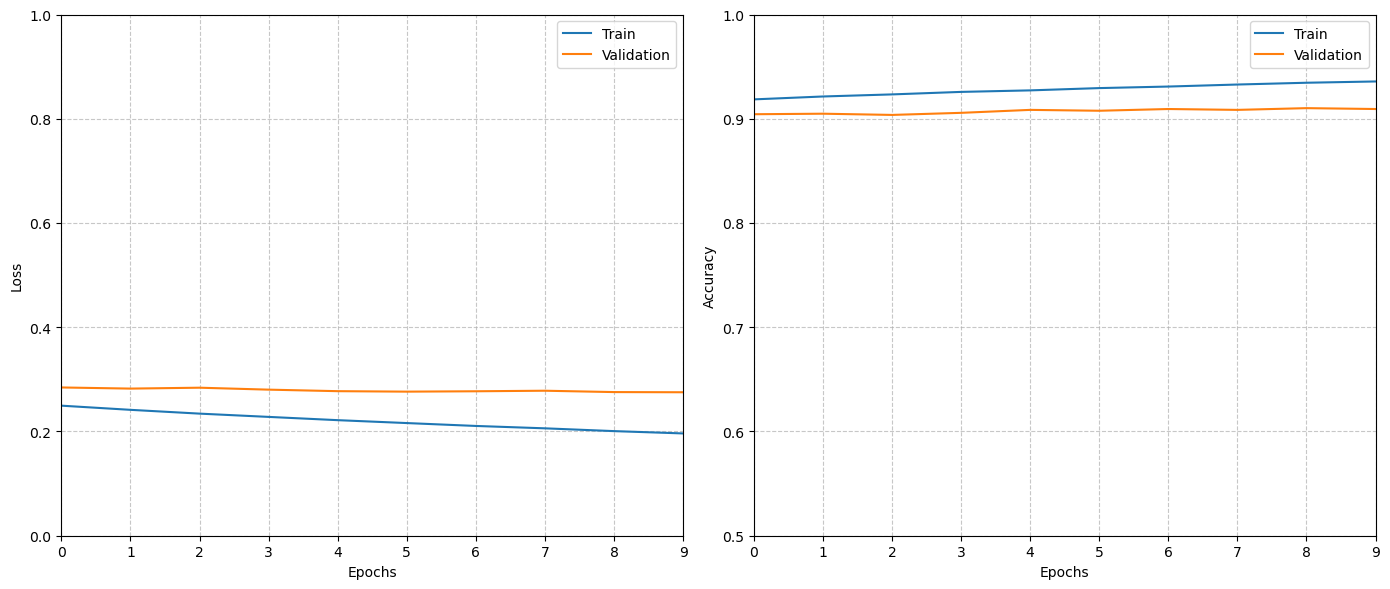

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Initialize empty lists to store the values
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

# Function to plot the metrics
def plot_metrics(epoch):
    clear_output(wait=True)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    colors = plt.get_cmap('tab10')

    # Plot Loss
    axs[0].plot(range(epoch + 1), train_loss_values, color=colors(0), label='Train')
    axs[0].plot(range(epoch + 1), val_loss_values, color=colors(1), label='Validation')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlim(0, EPOCHS - 1)
    axs[0].set_ylim(0, 1)
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.7)

    # Plot Accuracy
    axs[1].plot(range(epoch + 1), train_accuracy_values, color=colors(0), label='Train')
    axs[1].plot(range(epoch + 1), val_accuracy_values, color=colors(1), label='Validation')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlim(0, EPOCHS - 1)
    axs[1].set_ylim(0.5, 1)
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Loop through the epochs and append the values to the lists
for epoch in range(EPOCHS):
    metrics = trainer.iterate()
    train_loss_values.append(metrics['train_loss'])
    train_accuracy_values.append(metrics['train_accuracy'])
    val_loss_values.append(metrics['val_loss'])
    val_accuracy_values.append(metrics['val_accuracy'])

    # Plot the metrics after each epoch
    plot_metrics(epoch)

# Final plot to ensure the complete metrics are visible at the end
#plot_metrics(EPOCHS - 1)